In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, plot_roc_curve, classification_report

from sklearn.tree import DecisionTreeClassifier

from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.datasets import make_classification

import string

In [2]:
X,y = make_classification(n_samples=50_000, n_features=10, n_informative=3, n_classes=2, weights=[.95])

In [3]:
column_names = ['num__' + str(x) for x in range(1,11)]

In [4]:
column_names

['num__1',
 'num__2',
 'num__3',
 'num__4',
 'num__5',
 'num__6',
 'num__7',
 'num__8',
 'num__9',
 'num__10']

In [5]:
column_names.append('target')

In [6]:
pd.Series(y)

0        0
1        0
2        0
3        1
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Length: 50000, dtype: int32

In [7]:
df = pd.concat([pd.DataFrame(X),pd.Series(y)], axis=1)
df.columns = column_names

In [8]:
df.head()

,num__1,num__2,num__3,num__4,num__5,num__6,num__7,num__8,num__9,num__10,target
0,0.482061,-0.900028,-0.559278,-0.185681,-2.316284,-2.848956,0.936779,1.646479,-1.473565,0.162436,0
1,0.687614,1.465527,1.024936,0.063998,0.719797,-0.472872,0.167993,1.911739,1.944738,2.421404,0
2,0.408130,1.298778,1.011515,-0.289488,-0.008554,-1.520466,-0.133465,-0.534135,1.317713,2.428630,0
3,1.436133,1.899269,-0.916482,-0.306133,1.827398,0.638768,0.895514,-1.373805,-1.456214,-1.450450,1
4,1.085281,-3.122719,0.698015,-0.745301,-2.974233,-1.309127,-0.394161,-0.562856,-2.757525,-2.411014,0


In [9]:
df['cat_1'] = np.random.choice(a=['a','b','c','d','e'],  size=len(df))
df['cat_2'] = np.random.choice(a=['f','g','h','i'],  size=len(df))

In [10]:
df.head()

,num__1,num__2,num__3,num__4,num__5,num__6,num__7,num__8,num__9,num__10,target,cat_1,cat_2
0,0.482061,-0.900028,-0.559278,-0.185681,-2.316284,-2.848956,0.936779,1.646479,-1.473565,0.162436,0,b,g
1,0.687614,1.465527,1.024936,0.063998,0.719797,-0.472872,0.167993,1.911739,1.944738,2.421404,0,b,h
2,0.408130,1.298778,1.011515,-0.289488,-0.008554,-1.520466,-0.133465,-0.534135,1.317713,2.428630,0,c,h
3,1.436133,1.899269,-0.916482,-0.306133,1.827398,0.638768,0.895514,-1.373805,-1.456214,-1.450450,1,d,f
4,1.085281,-3.122719,0.698015,-0.745301,-2.974233,-1.309127,-0.394161,-0.562856,-2.757525,-2.411014,0,a,h


In [11]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [12]:
X = df.drop('target',axis =1)
y = df.target

In [13]:
# holdout split. I will call this validation
X_train_both, X_val, y_train_both, y_val = train_test_split(X,y,random_state=42, test_size = .1)

In [14]:
# Sniff Test
y_val.value_counts(normalize=True)

0    0.9422
1    0.0578
Name: target, dtype: float64

In [15]:
y_train_both.value_counts(normalize=True)

0    0.945711
1    0.054289
Name: target, dtype: float64

In [16]:
# Now, create my test and train splits for model creation, default test size
X_train, X_test, y_train, y_test = train_test_split(X_train_both, y_train_both, random_state=42)

In [17]:
print(f'Train size:     {X_train.shape}')
print(f'Test size:      {X_test.shape}')
print(f'Validation size {X_val.shape}')

Train size:     (33750, 12)
Test size:      (11250, 12)
Validation size (5000, 12)


In [18]:
# cat and numeric subpipe

subpipe_numerics = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler())
])


subpipe_cat = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [19]:
# Column Transformer

CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include=object))
], remainder='passthrough')

In [20]:
y_train.value_counts(normalize=True)

0    0.945096
1    0.054904
Name: target, dtype: float64

In [21]:
# Dummy!
dummy_model_pipe = Pipeline(steps=[
    ('ct',CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [22]:
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022FAA5DF280>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

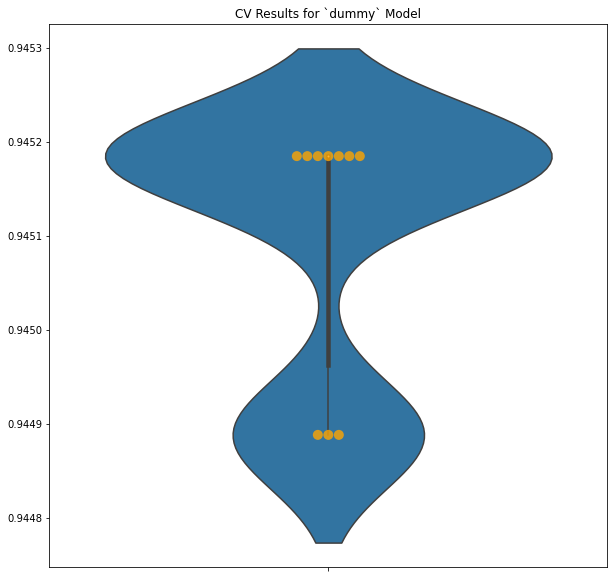

In [23]:
# Cross Validated on Training Data
dummy_model = ModelWithCV(
    dummy_model_pipe,
    model_name='dummy',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

dummy_model.plot_cv(ax=ax)

In [24]:
dummy_model.print_cv_summary()

CV Results for `dummy` model:
            0.94510 ± 0.00014 accuracy
        


In [25]:
dummy_model_pipe.score(X_test, y_test)

0.9475555555555556

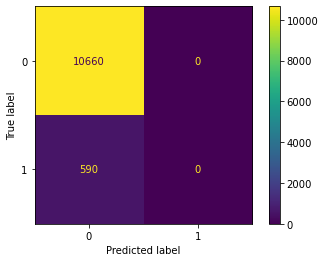

In [26]:
plot_confusion_matrix(dummy_model_pipe, X_test, y_test);

In [27]:
y_pred = dummy_model_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     10660
           1       0.00      0.00      0.00       590

    accuracy                           0.95     11250
   macro avg       0.47      0.50      0.49     11250
weighted avg       0.90      0.95      0.92     11250



c:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


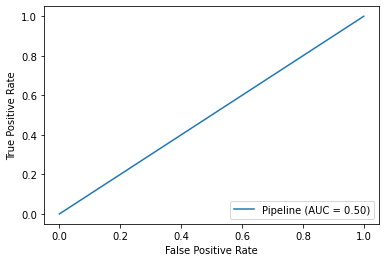

In [28]:
plot_roc_curve(dummy_model_pipe, X_test, y_test);

In [29]:
# FSM!

In [30]:
base_log_reg_pipe = Pipeline(steps=[
    ('ct',CT),
    ('base_log_reg', LogisticRegression(random_state=42))
])

In [31]:
base_log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022FAA5DF280>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

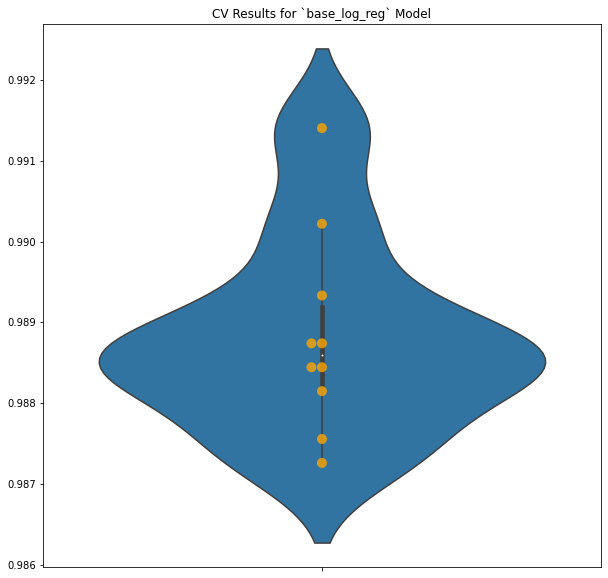

In [32]:
base_log_reg = ModelWithCV(
    base_log_reg_pipe,
    model_name='base_log_reg',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

base_log_reg.plot_cv(ax=ax);

In [33]:
base_log_reg.print_cv_summary()

CV Results for `base_log_reg` model:
            0.98883 ± 0.00117 accuracy
        


In [34]:
base_log_reg_pipe.score(X_test, y_test)

0.9880888888888889

In [35]:
y_pred = base_log_reg_pipe.predict(X_test)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10660
           1       0.97      0.79      0.87       590

    accuracy                           0.99     11250
   macro avg       0.98      0.90      0.93     11250
weighted avg       0.99      0.99      0.99     11250



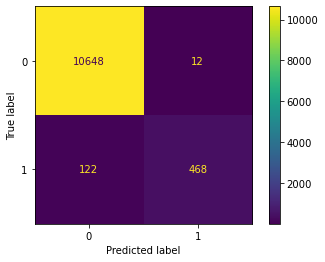

In [37]:
plot_confusion_matrix(base_log_reg_pipe, X_test, y_test)

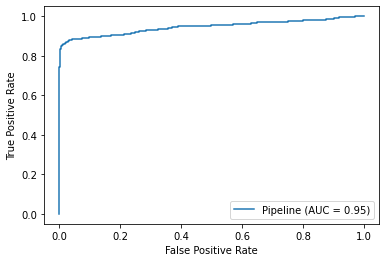

In [38]:
plot_roc_curve(base_log_reg_pipe, X_test, y_test)

In [39]:
# DT
base_dtc_pipe = Pipeline(steps=[
    ('ct',CT),
    ('base_dtc', DecisionTreeClassifier(random_state=42))
])

In [40]:
base_dtc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022FAA5DF280>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

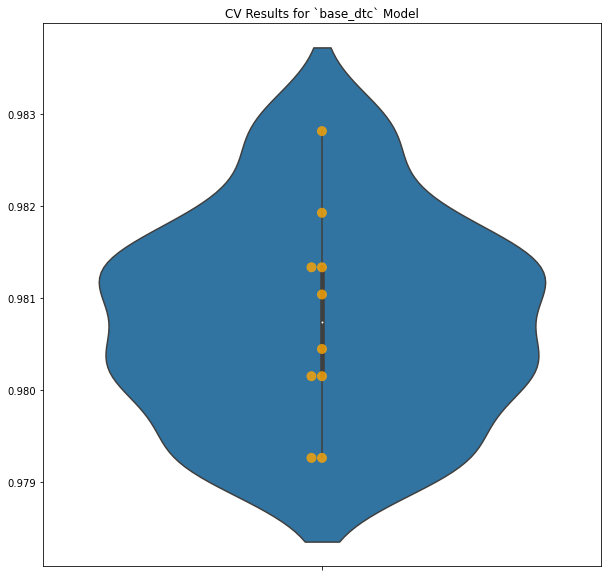

In [41]:
base_dtc = ModelWithCV(
    base_dtc_pipe,
    model_name='base_dtc',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

base_dtc.plot_cv(ax=ax);

In [42]:
base_dtc.print_cv_summary()

CV Results for `base_dtc` model:
            0.98077 ± 0.00108 accuracy
        


In [43]:
base_dtc_pipe.score(X_test, y_test)

0.9795555555555555

In [44]:
y_pred = base_dtc_pipe.predict(X_test)

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10660
           1       0.80      0.82      0.81       590

    accuracy                           0.98     11250
   macro avg       0.89      0.90      0.90     11250
weighted avg       0.98      0.98      0.98     11250



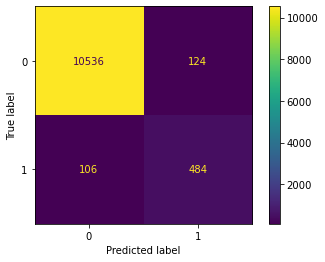

In [46]:
plot_confusion_matrix(base_dtc_pipe, X_test, y_test);

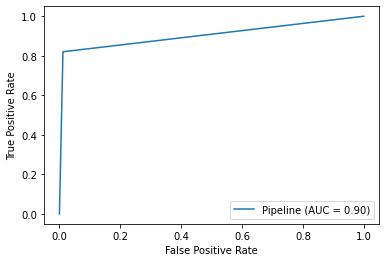

In [47]:
plot_roc_curve(base_dtc_pipe, X_test, y_test)

In [48]:
# IMBPIPE!!!!

In [49]:
imb_pipe = ImPipeline(steps=[
    ('ct',CT),
    ('sm',SMOTE(random_state=42, sampling_strategy=.25)),
    ('dtc',DecisionTreeClassifier(random_state=42))
])

In [50]:
imb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022FAA5DF280>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

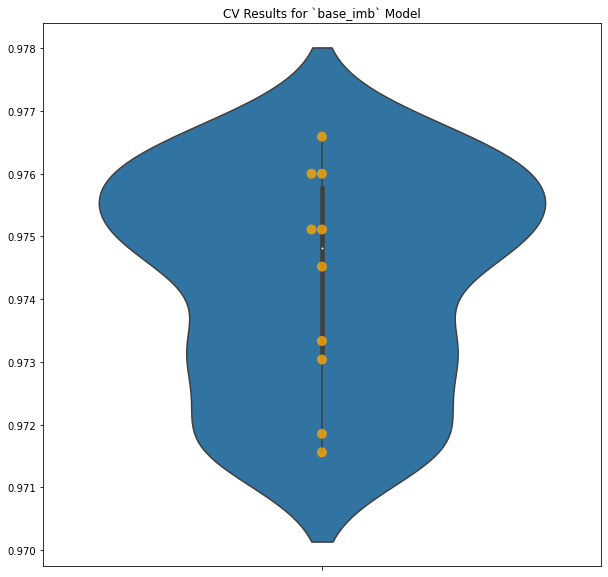

In [51]:
base_imb = ModelWithCV(
    imb_pipe,
    model_name='base_imb',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

base_imb.plot_cv(ax=ax);

In [52]:
base_imb.print_cv_summary()

CV Results for `base_imb` model:
            0.97431 ± 0.00169 accuracy
        


In [53]:
imb_pipe.score(X_test, y_test)

0.9721777777777778

In [54]:
parameters = {'dtc__criterion': ['gini', 'entropy'],
          'dtc__min_samples_leaf': [10, 15, 20],
          'sm__k_neighbors': [9, 11, 13]}

gs = GridSearchCV(estimator=imb_pipe,
                 param_grid=parameters,
                 cv=5,
                 verbose=2)

In [55]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9, total=   0.5s
[CV] dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9, total=   0.5s
[CV] dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9 
[CV]  dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9, total=   0.5s
[CV] dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9 
[CV]  dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9, total=   0.5s
[CV] dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9 
[CV]  dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9, total=   0.5s
[CV] dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=11 
[CV]  dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=11, total=   0.5s
[CV] dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=11 
[CV]  dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=11, total=   0.5s
[CV] dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=11 
[CV]  dtc__criterion=gini, dtc__min_samples_leaf=10, 

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   45.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000022FAA5DF280>),
                                                                        ('subpipe_cat',
                                                                         Pipe

In [56]:
gs.best_params_

{'dtc__criterion': 'gini', 'dtc__min_samples_leaf': 20, 'sm__k_neighbors': 9}

In [57]:
gs.best_params_

{'dtc__criterion': 'gini', 'dtc__min_samples_leaf': 20, 'sm__k_neighbors': 9}

In [58]:
gs.best_score_

0.9839111111111111

In [59]:
gs.best_estimator_.score(X_test, y_test)

0.9839111111111111

In [60]:
final_model = gs.best_estimator_

In [61]:
final_model

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022FADA01790>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [62]:
# Train with our combined train/test

final_model.fit(X_train_both, y_train_both)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022FADA01790>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

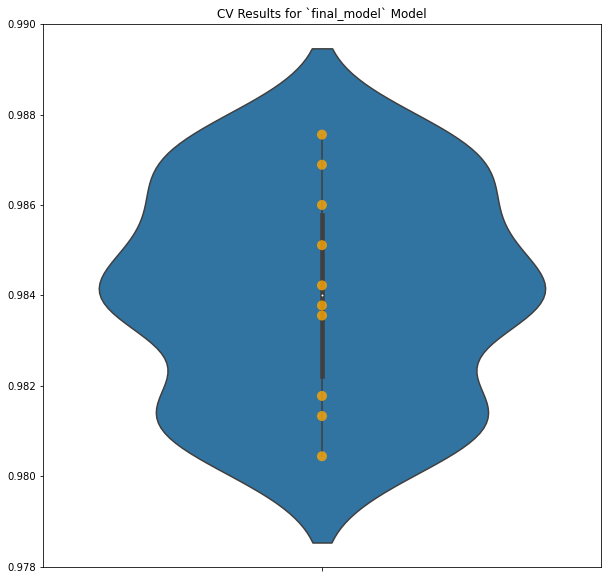

In [63]:
final_model_check = ModelWithCV(
    final_model,
    model_name='final_model',
    X=X_train_both,
    y=y_train_both)
fig, ax = plt.subplots(figsize=(10,10))

final_model_check.plot_cv(ax=ax);

In [64]:
final_model_check.print_cv_summary()

CV Results for `final_model` model:
            0.98407 ± 0.00226 accuracy
        


In [65]:
# Score against validation/hold out

final_model.score(X_val, y_val)

0.988

In [66]:
# production model
final_model.fit(X,y)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022FADA01790>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       